In [ ]:
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns


# Replace with your actual folder paths
adata1 = sc.read_h5ad("Preprocess_data/10XGenomics_counts_adata.h5ad")
adata2 = sc.read_h5ad("Preprocess_data/vasa-seq_counts_adata.h5ad")
adata3 = sc.read_h5ad("Preprocess_data/SSTX_counts_adata.h5ad")


/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/users/isakova/.local/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Remove cells with very low UMI count in TotalX (there are very few)

In [2]:
min_umi_threshold = 5000

# Compute total UMIs per cell
adata3.obs['n_counts'] = np.array(adata3.X.sum(axis=1)).flatten()
# Filter cells
adata3 = adata3[adata3.obs['n_counts'] >= min_umi_threshold].copy()
print(f"adata3: retained {adata3.n_obs} cells (≥{min_umi_threshold} UMIs)")


adata3: retained 11945 cells (≥5000 UMIs)


### Keep genes matching official geneIDs if they start with ESNG

In [3]:
## Remove non-confirming ids, i.e. not present in the used annotation

def filter_genes_by_reference(adata_target, adata_reference, gene_id_col='gene_ids', ens_prefix='ENSG'):
    """
    Filters adata_target to keep genes that are either present in adata_reference 
    or do not start with the specified prefix (default 'ENSG').
    """
    # Check if gene_id_col exists in both AnnData objects
    if gene_id_col in adata_target.var.columns and gene_id_col in adata_reference.var.columns:
        ref_gene_ids = set(adata_reference.var[gene_id_col])
        
        # Mark genes to keep
        adata_target.var['keep'] = adata_target.var[gene_id_col].apply(
            lambda x: (x in ref_gene_ids) or not x.startswith(ens_prefix)
        )
        
        # Subset and clean up
        adata_target = adata_target[:, adata_target.var['keep']].copy()
        del adata_target.var['keep']
        
        print(f"Non-matched gene_ids starting with '{ens_prefix}' have been removed from adata.")
    else:
        print(f"{gene_id_col} column is not present in one of the AnnData objects.")
    
    return adata_target

adata2 = filter_genes_by_reference(adata2, adata3)
adata1 = filter_genes_by_reference(adata1, adata3)


Non-matched gene_ids starting with 'ENSG' have been removed from adata.
Non-matched gene_ids starting with 'ENSG' have been removed from adata.


### Create adata list and compute a few stats

10XGenomics:
  Number of cells: 4807
  Mean UMIs per cell: 30155.17
  Median UMIs per cell: 29888.00
  Max UMIs per cell: 150594.00

VASA-seq:
  Number of cells: 877
  Mean UMIs per cell: 41322.18
  Median UMIs per cell: 32481.00
  Max UMIs per cell: 193481.00

TotalX:
  Number of cells: 11945
  Mean UMIs per cell: 18075.30
  Median UMIs per cell: 14985.00
  Max UMIs per cell: 133796.00



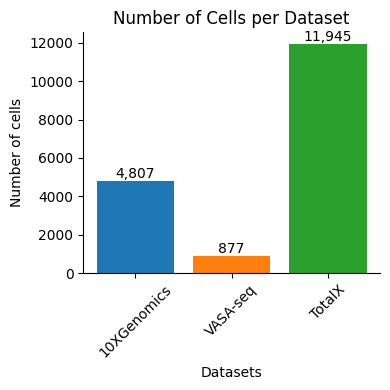

In [4]:
titles = ["10XGenomics",  "VASA-seq", "TotalX"]

adata_list = [adata1,  adata2, adata3]
import matplotlib.pyplot as plt

# Prepare lists to hold dataset info
num_cells_list = []
dataset_labels = []

# Loop through your adata_list and collect stats
for i, adata in enumerate(adata_list):
    total_counts = np.array(adata.X.sum(axis=1)).flatten()
    
    num_cells = adata.n_obs
    mean_umis = total_counts.mean()
    median_umis = np.median(total_counts)
    max_umis = total_counts.max()
    
    num_cells_list.append(num_cells)
    dataset_labels.append(titles[i])
    
    print(f"{titles[i]}:")
    print(f"  Number of cells: {num_cells}")
    print(f"  Mean UMIs per cell: {mean_umis:.2f}")
    print(f"  Median UMIs per cell: {median_umis:.2f}")
    print(f"  Max UMIs per cell: {max_umis:.2f}")
    print()

colors = plt.get_cmap('tab10').colors

# Plot number of cells per dataset
plt.figure(figsize=(4, 4))
bars = plt.bar(dataset_labels, num_cells_list, color=colors[:len(dataset_labels)] )
# Add text labels on top of each bar
for bar, count in zip(bars, num_cells_list):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{count:,}",  # format with commas for thousands
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.ylabel("Number of cells")
plt.xlabel("Datasets")
plt.title("Number of Cells per Dataset")
plt.xticks(rotation=45)
# Remove top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


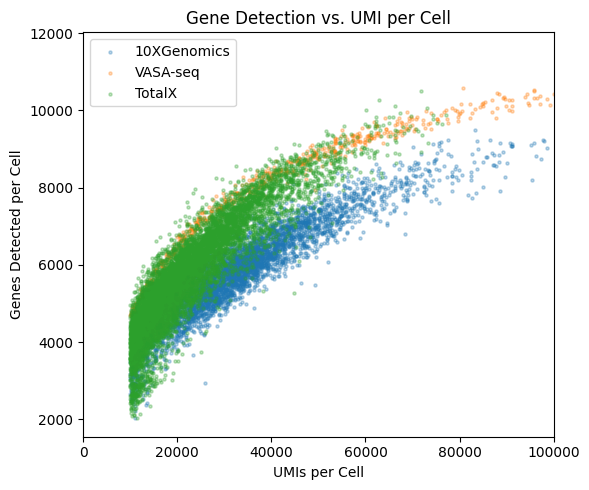

In [5]:
def prepare_unique_genes(adata):
    """
    Clean GeneNames and remove duplicate genes.
    """
    adata.var['GeneName'] = adata.var['GeneName'].str.split('.').str[0]
    unique_gene_mask = ~adata.var['GeneName'].duplicated(keep=False)
    return adata[:, unique_gene_mask].copy()

plt.figure(figsize=(6, 5))
for adata, title in zip(adata_list, titles):
    adata_unique = prepare_unique_genes(adata)
    adata_unique.obs['n_counts'] = adata_unique.X.sum(axis=1).A1
    adata_unique.obs['n_genes'] = (adata_unique.X > 0).sum(axis=1).A1
    adata_filtered = adata_unique[adata_unique.obs['n_counts'] >= 10000]
    plt.scatter(adata_filtered.obs['n_counts'], adata_filtered.obs['n_genes'], alpha=0.3, label=title, s=5)

plt.xlabel("UMIs per Cell")
plt.ylabel("Genes Detected per Cell")
plt.legend()
plt.xlim(0,100000)
plt.title("Gene Detection vs. UMI per Cell")
plt.tight_layout()
plt.show()

### Figure 1d

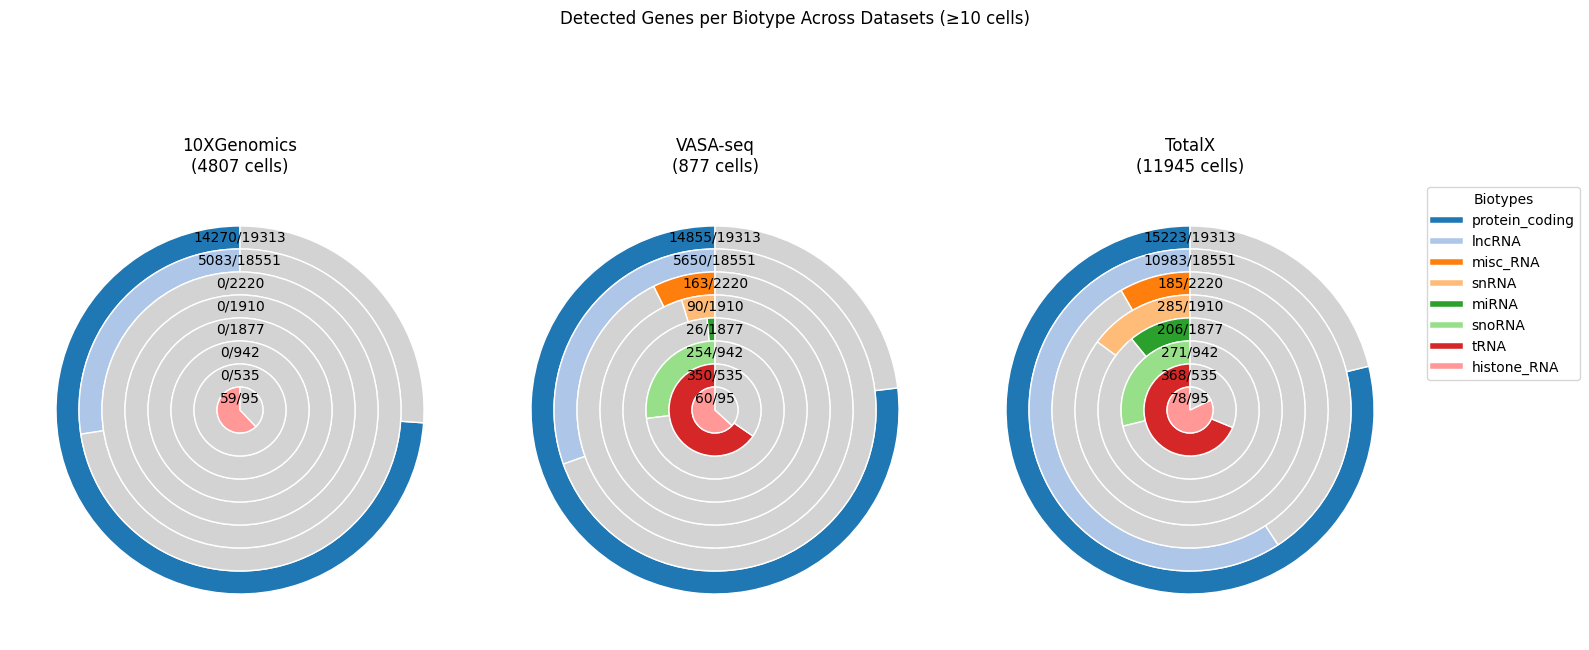

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Target biotypes
target_biotypes = ["protein_coding", "lncRNA", "misc_RNA", "snRNA", "miRNA", "snoRNA", "tRNA", "histone_RNA"]

# Dynamic detection threshold
detection_threshold = 10  # <<< CHANGE THIS IF NEEDED

def calculate_detected_genes_by_biotype(adata, biotype_col='biotype', target_biotypes=None, detection_threshold=10):
    if biotype_col not in adata.var.columns:
        raise ValueError(f"'{biotype_col}' column not found in adata.var")

    detected_in_cells = (adata.X > 0).sum(axis=0).A1
    detected_genes_mask = detected_in_cells >= detection_threshold
    detected_biotypes = adata.var.loc[detected_genes_mask, biotype_col]

    return {biotype: (detected_biotypes == biotype).sum() for biotype in target_biotypes}

def count_total_genes_by_biotype(adata, biotype_col='biotype', target_biotypes=None):
    if biotype_col not in adata.var.columns:
        raise ValueError(f"'{biotype_col}' column not found in adata.var")

    return {biotype: (adata.var[biotype_col] == biotype).sum() for biotype in target_biotypes}

def prepare_normalized_doughnut_data(detected_genes_by_biotype, adata3_total_genes_by_biotype):
    fractions_by_biotype = {}
    for dataset, detected in detected_genes_by_biotype.items():
        fractions_by_biotype[dataset] = {}
        for biotype in target_biotypes:
            detected_count = detected.get(biotype, 0)
            total_adata3 = adata3_total_genes_by_biotype.get(biotype, 0)
            fraction = detected_count / total_adata3 if total_adata3 > 0 else 0
            fraction = max(0, min(fraction, 1))
            fractions_by_biotype[dataset][biotype] = fraction
    return fractions_by_biotype



detected_genes_by_biotype = {
    title: calculate_detected_genes_by_biotype(
        adata,
        biotype_col="biotype",
        target_biotypes=target_biotypes,
        detection_threshold=detection_threshold
    )
    for adata, title in zip(adata_list, titles)
}


adata3_total_genes_by_biotype = count_total_genes_by_biotype(
    adata3, biotype_col="biotype", target_biotypes=target_biotypes
)

fractions_by_biotype_normalized = prepare_normalized_doughnut_data(
    detected_genes_by_biotype, adata3_total_genes_by_biotype
)


# Compute the number of cells per dataset
n_cells_per_dataset = {title: adata.n_obs for adata, title in zip(adata_list, titles)}

# Plotting
fig, axes = plt.subplots(1, len(fractions_by_biotype_normalized), figsize=(16, 8))
if len(fractions_by_biotype_normalized) == 1:
    axes = [axes]

colors = plt.cm.tab20.colors[:len(target_biotypes)]

for i, (dataset, fractions) in enumerate(fractions_by_biotype_normalized.items()):
    ax = axes[i]
    size = 1.0
    width = 1.0 / len(target_biotypes)

    for j, biotype in enumerate(target_biotypes):
        fraction = fractions.get(biotype, 0)
        detected_count = detected_genes_by_biotype[dataset].get(biotype, 0)
        total_count = adata3_total_genes_by_biotype.get(biotype, 1)

        fraction = max(0, min(fraction, 1))
        ax.pie(
            [fraction, 1 - fraction],
            radius=size,
            labels=None,
            startangle=90,
            colors=[colors[j], 'lightgray'],
            wedgeprops=dict(width=width, edgecolor='white'),
        )
        ax.text(
            0,
            size - (width / 2),
            f"{detected_count}/{total_count}",
            ha="center",
            va="center",
            fontsize=10,
            color="black",
        )
        size -= width

    # Add dataset name and cell count
    ax.set_title(f"{dataset}\n({n_cells_per_dataset[dataset]} cells)")

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    labels=target_biotypes,
    title="Biotypes",
    handles=[plt.Line2D([0], [0], color=colors[j], lw=4) for j in range(len(target_biotypes))]
)

plt.suptitle(f"Detected Genes per Biotype Across Datasets (≥{detection_threshold} cells)")
plt.tight_layout()
plt.show()


### Use common ID space to compute genes vs UMIs

In [7]:
def filter_genes_by_reference(adata_target, adata_reference, gene_id_col='gene_ids'):
    """
    Filters adata_target to keep only genes whose gene_id_col values 
    are present in adata_reference.
    """
    # Check if gene_id_col exists in both AnnData objects
    if gene_id_col in adata_target.var.columns and gene_id_col in adata_reference.var.columns:
        ref_gene_ids = set(adata_reference.var[gene_id_col])
        
        # Keep only matching gene IDs
        adata_target.var['keep'] = adata_target.var[gene_id_col].isin(ref_gene_ids)
        
        # Subset and clean up
        adata_target = adata_target[:, adata_target.var['keep']].copy()
        del adata_target.var['keep']
        
        print(f"Filtered to genes present in the reference AnnData object.")
    else:
        print(f"{gene_id_col} column is not present in one of the AnnData objects.")
    
    return adata_target

adata2 = filter_genes_by_reference(adata2, adata3)
adata1 = filter_genes_by_reference(adata1, adata3)

### Check whether names are unique
def check_gene_name_uniqueness(adata, adata_name='adata'):
    if 'GeneName' in adata.var.columns:
        if adata.var['GeneName'].is_unique:
            print(f"The 'GeneName' column is unique in {adata_name}.")
        else:
            print(f"The 'GeneName' column is NOT unique in {adata_name}.")
            duplicated_gene_names = adata.var['GeneName'][adata.var['GeneName'].duplicated()]
            print("Duplicated gene names:")
            print(duplicated_gene_names.values)
    else:
        print(f"'GeneName' column not found in {adata_name}.")


check_gene_name_uniqueness(adata1, 'adata1')
check_gene_name_uniqueness(adata2, 'adata2')
check_gene_name_uniqueness(adata3, 'adata3')



Filtered to genes present in the reference AnnData object.
Filtered to genes present in the reference AnnData object.
The 'GeneName' column is NOT unique in adata1.
Duplicated gene names:
['AL627309' 'AL627309' 'AL627309' ... 'AC171558' 'AC007325' 'AC007325']
The 'GeneName' column is NOT unique in adata2.
Duplicated gene names:
['RNU2' 'RNU2' 'MT' ... 'RNU6' 'AL451164' 'MIR1302']
The 'GeneName' column is NOT unique in adata3.
Duplicated gene names:
['Y_RNA' 'Y_RNA' 'Y_RNA' ... 'U6' 'U6' 'U1']


/tmp/ipykernel_581/3908780421.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genes_per_bin = adata.obs.groupby('read_bins')['n_genes'].mean()
/tmp/ipykernel_581/3908780421.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genes_per_bin = adata.obs.groupby('read_bins')['n_genes'].mean()
/tmp/ipykernel_581/3908780421.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genes_per_bin = adata.obs.groupby('read_bins'

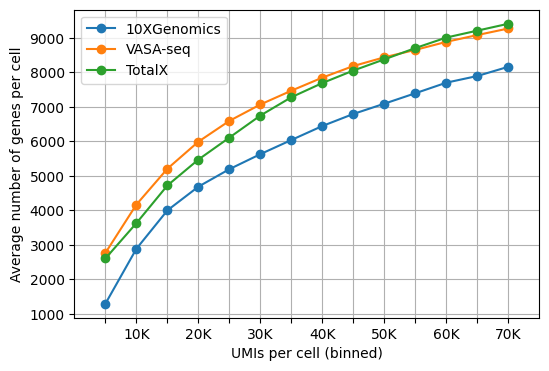

In [ ]:
### Plot number of all genes by GeneName
# 
# # Ensure 'n_counts' is calculated for each dataset
for adata in adata_list:
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)

# Define bin edges such that midpoints are 5K, 10K, 15K, etc.
bin_midpoints = np.arange(5000, 75000, 5000)
bins = np.concatenate([[0], bin_midpoints + 2500])  # Create bin edges with midpoints centered

def compute_genes_per_read_bin(adata, bins):
    if 'GeneName' not in adata.var.columns:
        raise ValueError("GeneName column not found in adata.var")

    # Remove everything after '.' in GeneName
    adata.var['GeneName'] = adata.var['GeneName'].str.split('.').str[0]

    # Deduplicate by GeneName
    unique_gene_mask = ~adata.var['GeneName'].duplicated(keep=False)
    adata_unique = adata[:, unique_gene_mask]


    # Total counts should remain unchanged
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, 'A1') else adata.X.sum(axis=1)

    # Calculate unique genes per cell
    adata.obs['n_genes'] = (adata_unique.X > 0).sum(axis=1).A1 if hasattr(adata_unique.X, 'A1') else (adata_unique.X > 0).sum(axis=1)

    # Bin cells by total counts
    adata.obs['read_bins'] = pd.cut(adata.obs['n_counts'], bins=bins)

    # Aggregate mean number of unique genes per bin
    genes_per_bin = adata.obs.groupby('read_bins')['n_genes'].mean()
    return genes_per_bin

# Calculate genes per bin for each dataset
genes_per_bin_results = [
    compute_genes_per_read_bin(adata, bins) for adata in adata_list
]


# Plot the results
plt.figure(figsize=(6, 4))
for genes_per_bin, title in zip(genes_per_bin_results, titles):
    plt.plot(bin_midpoints, genes_per_bin, marker='o', linestyle='-', label=title)

# Formatting the plot
plt.xlabel('UMIs per cell (binned)')
plt.ylabel('Average number of genes per cell')
xticks = bin_midpoints
plt.xticks(
    ticks=xticks,
    labels=[f'{int(mid / 1000)}K' if i % 2 == 1 else '' for i, mid in enumerate(bin_midpoints)]
)
plt.legend()
plt.xlim(0,75000)
plt.grid()
plt.show()

Processing 10XGenomics ...
10XGenomics: Removed cells with >45000 UMIs, 4052 cells remaining.
10XGenomics: 2776 cells with ≥20000 UMIs (out of 4052)
10XGenomics: Retaining 21082 genes detected in >0 cells.


Random UMI Downsampling: 100%|██████████| 2776/2776 [00:01<00:00, 1523.00it/s]


Processing VASA-seq ...
VASA-seq: Removed cells with >45000 UMIs, 603 cells remaining.
VASA-seq: Small dataset (n=603), keeping all cells.
VASA-seq: Retaining 22012 genes detected in >0 cells.


Random UMI Downsampling: 100%|██████████| 603/603 [00:00<00:00, 3072.11it/s]


Processing TotalX ...
TotalX: Removed cells with >45000 UMIs, 11599 cells remaining.
TotalX: 3705 cells with ≥20000 UMIs (out of 11599)
TotalX: Retaining 35496 genes detected in >0 cells.


Random UMI Downsampling: 100%|██████████| 3705/3705 [00:02<00:00, 1449.24it/s]
/tmp/ipykernel_581/1636576643.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data=df, x="Dataset", y="Total Genes per Cell", inner="box", scale="width", palette="tab10")
/tmp/ipykernel_581/1636576643.py:107: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(data=df, x="Dataset", y="Total Genes per Cell", inner="box", scale="width", palette="tab10")


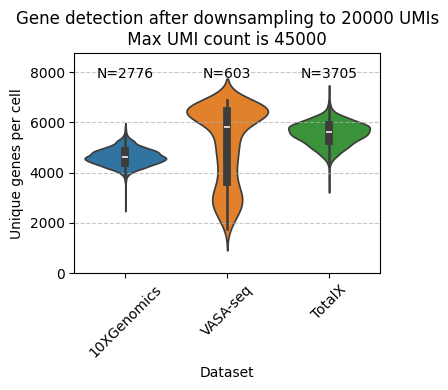

In [10]:
import scipy.sparse as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def downsample_umis(adata, target_umis=20000):
    """
    Randomly downsample each cell to target_umis if total UMIs exceed target_umis.
    Cells with fewer than target_umis UMIs remain unchanged.
    """
    X = adata.X.tocsr() if sp.issparse(adata.X) else sp.csr_matrix(adata.X)
    downsampled_rows = []
    for i in tqdm(range(X.shape[0]), desc="Random UMI Downsampling"):
        counts = X[i].toarray().flatten()
        total = counts.sum()
        if total <= target_umis:
            downsampled_rows.append(counts)
        else:
            gene_indices = np.repeat(np.arange(len(counts)), counts.astype(int))
            sampled_indices = np.random.choice(gene_indices, target_umis, replace=False)
            sampled_counts = np.bincount(sampled_indices, minlength=len(counts))
            downsampled_rows.append(sampled_counts)
    return sp.csr_matrix(np.vstack(downsampled_rows))


def prepare_unique_genes_by_name(adata):
    """
    Deduplicate genes by cleaned GeneName (remove .1, .2 suffixes).
    Keep only unique, non-NA GeneNames.
    """
    adata = adata.copy()
    adata.var['GeneName'] = adata.var['GeneName'].astype(str).str.strip().str.split('.').str[0]

    valid_mask = adata.var['GeneName'].notna() & (adata.var['GeneName'] != '') & (adata.var['GeneName'] != 'nan')
    adata = adata[:, valid_mask].copy()

    unique_mask = ~adata.var['GeneName'].duplicated(keep=False)
    adata = adata[:, unique_mask].copy()

    return adata

# Parameters
target_umis_per_cell = 20000
umi_threshold_if_large = 20000
small_dataset_cutoff = 1000
target_cells = 10000
max_umis = 45000

total_genes_per_cell = []
dataset_counts = {}

for adata, title in zip(adata_list, titles):
    print(f"Processing {title} ...")

    # Step 1: Deduplicate and clean by GeneName
    adata_clean = prepare_unique_genes_by_name(adata)

    # Step 2: Compute total UMIs per cell
    adata_clean.obs['n_counts'] = adata_clean.X.sum(axis=1).A1
    # Step 2.5: Filter out cells with >max UMIs to avoid bias (thats were most cells fall into)
    adata_clean = adata_clean[adata_clean.obs['n_counts'] <= max_umis].copy()
    print(f"{title}: Removed cells with >{max_umis} UMIs, {adata_clean.n_obs} cells remaining.")

    total_cells = adata_clean.n_obs

    # Step 3: Filter cells with sufficient UMIs
    if total_cells > small_dataset_cutoff:
        adata_filtered = adata_clean[adata_clean.obs['n_counts'] >= umi_threshold_if_large].copy()
        print(f"{title}: {adata_filtered.n_obs} cells with ≥{umi_threshold_if_large} UMIs (out of {total_cells})")
    else:
        adata_filtered = adata_clean.copy()
        print(f"{title}: Small dataset (n={total_cells}), keeping all cells.")

    if adata_filtered.n_obs == 0:
        print(f"{title}: Skipped (no cells pass filter).")
        continue

    # Step 3.5: Filter out genes detected in <1 cells
    gene_counts = (adata_filtered.X > 0).sum(axis=0).A1
    keep_genes = gene_counts > 0
    adata_filtered = adata_filtered[:, keep_genes].copy()
    print(f"{title}: Retaining {keep_genes.sum()} genes detected in >0 cells.")

    # Step 4: Downsample each cell to exactly 20K UMIs
    downsampled_X = downsample_umis(adata_filtered, target_umis=target_umis_per_cell)
    downsampled_totals = downsampled_X.sum(axis=1).A1
    assert np.all(downsampled_totals <= target_umis_per_cell), "Some cells exceed downsampling target!"

    # Step 5: Count detected genes per cell
    n_genes_per_cell = (downsampled_X > 0).sum(axis=1).A1
    adata_filtered.obs['downsampled_genes'] = n_genes_per_cell

    # Step 6: Sort by gene count and select top N
    adata_sorted = adata_filtered[adata_filtered.obs.sort_values("downsampled_genes", ascending=False).index]
    top_cells = adata_sorted[:min(target_cells, adata_sorted.n_obs)]

    # Step 7: Store for plotting
    dataset_counts[title] = top_cells.n_obs
    total_genes_per_cell.extend([(title, val) for val in top_cells.obs['downsampled_genes']])

# Plotting
df = pd.DataFrame(total_genes_per_cell, columns=["Dataset", "Total Genes per Cell"])

plt.figure(figsize=(4, 4))
ax = sns.violinplot(data=df, x="Dataset", y="Total Genes per Cell", inner="box", scale="width", palette="tab10")

# Annotate N per dataset
for i, dataset in enumerate(df['Dataset'].unique()):
    count = dataset_counts[dataset]
    ax.text(i, df["Total Genes per Cell"].max() * 1.05, f"N={count}",
            ha='center', va='bottom', fontsize=10)

plt.title(f"Gene detection after downsampling to {target_umis_per_cell} UMIs\n Max UMI count is {max_umis} ")
plt.ylabel("Unique genes per cell")
plt.xlabel("Dataset")
plt.xticks(rotation=45)
plt.ylim(0, df["Total Genes per Cell"].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
